In [95]:
import scipy.integrate
import math
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates

In [96]:
#Modelo SEIR++:
# S -> Susceptibles
# E -> Expuestos
# I -> Infectados
# R -> Recuperados
# B -> Beta, Tasa de transmisión
# D -> sensación pública de riesgo

# Esto se puede llevar después a una interfaz o cargar los datos

population = 12000000 #Aprox de la población
E0 = 3 # casos iniciales

m_total = 3 #cantidad de medidas tomadas
m_days = [ 0 for i in range(m_total)]
# Días en los que se tomaron nuevas medidas por parte del gobierno.
m_days[0] = 18 #Días hasta las primeras medidas
m_days[1] = 23 #Días hasta la 2da medida mayor (Pendiente>>MEJORAR VALORES)
m_days[2] = 30 #cuarentena total hipotética

daysTotal = 28 #Días analizados 
 
gamma = 1/7 #valor cambiante 
#gamma es la tasa de recuperación: 1/gamma será el período de tiempo medio (en días) de recuperación (pasa a ser no infector)

sigma = 1/5  #valor promedio relativamente fiel
# sigma es la velocidad con la que se transforma un expuesto en infector: 1/sigma es el período promedio de este cambio

r1 = 2.68 #Tasa básica de reproducción del COVID19 sin medidas tomadas, sería beta/gamma y algunas versiones del modelo usan r0 en vez de beta
# r es otro de los parámetros difíciles de estimar y que varía bastante, supuestamente r0 = 2.68 
r0 = 6.3 #Valor aproximado con los resultados reales
# en este caso tomamos r0 mucho mayor por causa de la cantidad de entradas de nuevos casos extranjeros y r1 será 2.68

beta0 = r0*gamma #Tasa de transmición inicial media sin medidas tomadas
beta1 = r1*gamma 
#beta es la tasa de transmisión, 1/beta representa mayormente la probabilidad de contagio luego de un contacto Inf - Suscep
#beta es de los párametros más complicados de estimar por la existencia de asintomáticos y de los más importantes en el modelo

alfa = [0 for i in range(m_total)]
# fuerza de las medidas tomadas por el gobierno de 0 a 1 un valor que determina beta y es dificil de estimar
# esto se puede tomar como una función constante a trozos y graficar según los cambios en alfa
alfa[0] = 0.1 #rigor de las medidas iniciales
alfa[1] = 0.3 #segundas medidas
alfa[2] = 0.5 #cuarentena de ~ 0.5? 
#alfa[2] = 0.65 #ESTO ES UN EJEMPLO DE MEDIDAS EFECTIVAS

k = 1117.3
#intensidad de la reacción de los individuos 

presympt_time = 5.2
#Tiempo medio en que demora la aparición de los sintomas, tiempo de incubación

noSymptoms = 0.35 
#porciento de personas asintomáticas

fRatio = 0.8 #De nuevo un valor optimista que depende del rigor de las medidas
#porciento de casos de infectados con síntomas detectados

findRatio = (1-noSymptoms) * fRatio
#porciento de casos de infectados detectados(se asume que todos son hospitalizados)

findTime = presympt_time + 3 # (MEJORABLE) Buscar más info
#tiempo medio en días que se demora en hospitalizar a un paciente infectado

timeInHospital = 14 #tiempo que se mantiene un paciente infectado en el hospital
timeInfected = 1.0 / gamma #duración media de la infección

UCI_count = 200  
#cantidad de unidades de cuidados intensivos disponibles en el país

CriticalRate = 0.05
#porciento de pacientes que necesitan cuidados intensivos

critical_lag = 5 #(Pendiente>>MEJORAR VALOR)
#tiempo medio en días que un paciente hospitalizado pasa a estado crítico

death_delay = 3 #(Pendiente>>MEJORAR VALOR)
#tiempo medio en días que un paciente en estado crítico muere

UCIFatalityRate = 0.023 # (Calculado en China)
#porciento de pacientes que utilizan UCIs y mueren

FatalityRate = CriticalRate * 0.95 # (Pendiente>>MEJORAR VALOR)
#porciento de pacientes críticos que mueren sin acceso a UCI

Hosp = [0 for i in range(daysTotal)]
#array con la cantidad de casos hospitalizados en un día dado

Critical = [0 for i in range(daysTotal)]
#array con la cantidad de casos críticos en un día dado     

In [97]:
#Model

def model(seir, t):
     
    S,E,I,R = seir
    N = S + E + I + R
    
    def D(I,t):
        return CriticalRate*I

    def Beta (I,t,N):
        if t < m_days[0]:
            return beta0
        if t < m_days[1]:
            return beta1
        else:
            for i in range (2,m_total):
                if t < m_days[i]:  
                    return beta1 * (1-alfa[i-1])* np.power((1-D(I,t)/N),k)
        return beta1 * (1-alfa[m_total-1])* np.power((1-D(I,t)/N),k)
    
    beta = Beta(I,t,N)
        
    dS = -1 * beta * S * I / N 
    dE = beta * S * I / N - sigma * E
    dI = sigma * E - gamma * I
    dR = gamma * I
    
    return dS, dE, dI, dR

def Solve ():
    X = np.arange(daysTotal)
    seir = population - E0, 0, E0, 0
    y_data_var = scipy.integrate.odeint(model, seir, X)
    S, E, I, R = y_data_var.T
    return X, S, E, I, R 

In [98]:
#Simple calendar

first_case_date = dates.datetime.date(2020,3,6) #Fecha de llegada (no de detección) del primer caso registrado
date00 = first_case_date

def calc_date(date0,days_passed):
    x = date0.toordinal() + days_passed  
    ans = date0.fromordinal(x)
    return ans    

In [99]:
#Solving and using the model:

X, S, E, I, R = Solve()

death_count = 0
deaths = [0 for i in range (0,daysTotal)]
Dprev = 0
Rprev = 0

lag = int(findTime)+1
clag = lag + critical_lag
dlag = death_delay

#Calcula la cantidad de hospitalizados, críticos y las muertes diarias
#Los hospitalizados y críticos forman parte del número de infectados y las muertes de los "recuperados"
for i in range (lag,daysTotal-1):
    Hosp[i] = I[i-lag] * findRatio
    Hosp[i] -= Hosp[i-timeInHospital]
    Critical[i] = I[i-clag] * CriticalRate
    needed_UCI = Critical[i-clag] - UCI_count #diferencia entre las UCIs actuales y las necesitadas
    precalc = 0
    if (needed_UCI > 0):
        precalc_FR = (UCIFatalityRate * UCI_count) * (UCI_count/Critical[i-clag]) + (FatalityRate *needed_UCI) * (needed_UCI/Critical[i-clag])      
    FR = UCIFatalityRate if Critical[i-clag] <= UCI_count else precalc_FR
    
    if i + dlag < daysTotal - 1:
        deaths[i+dlag] = FR * (R[i] - Rprev)
        death_count += deaths[i+dlag]
        Rprev = R[i]
        Dprev = deaths[i+dlag]    

In [100]:
# Stadistics

infected = E0  #total de infectados 
worstday = 0      #día con más infectados
maxinfects = 0    #máximo número de infectados
maxexposure = 0   #máximo número de población expuesta a la enfermedad (posibles contagios)
maxexposure_day = 0  #día de mayor exposición al contagio 

for i in range (daysTotal):
    if I[i] > maxinfects:
        worstday = i
        maxinfects = I[i]
    if R[i] > infected: infected = R[i]
    if E[i] > maxexposure:
        maxexposure_day = i
        maxexposure = E[i]

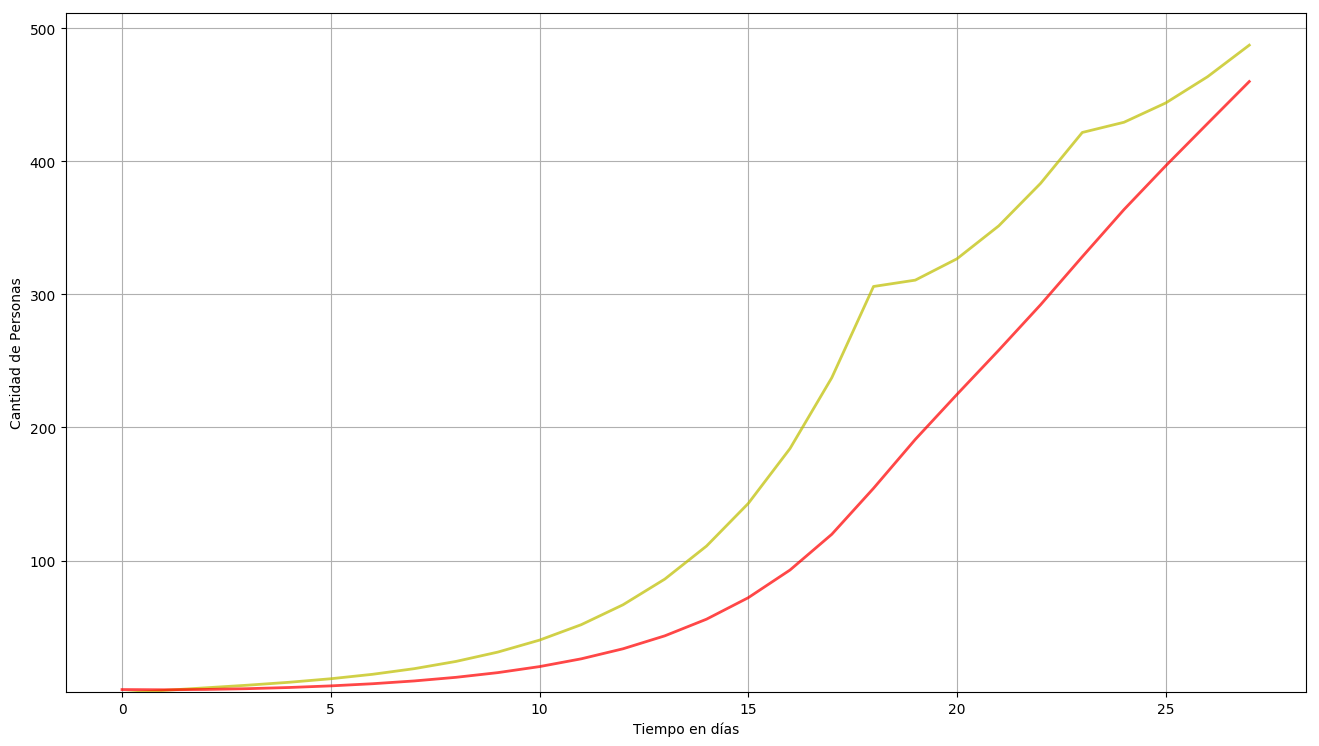

Total de contagiados:  485.0 ( 0.0 % de la población)
Muertes:  6.0 ( 0.0 % de la población)
Pico de infección: 2020-04-02 con un total de 485.0 infectados
Día de mayor exposición al virus: 2020-04-02 con un total de 487.0 expuestos


In [101]:
#Plot Section

fig = plt.figure(dpi=100, figsize=(16,9))
ax = fig.add_subplot(111)

#ax.plot(X, S, 'b', alpha=0.72, lw=2, label='Susceptibles(t)')
ax.plot(X, E, 'y', alpha=0.72, lw=2, label='Expuestos (t)')
ax.plot(X, I, 'r', alpha=0.72, lw=2, label='Infectados (t)')
#ax.plot(X, R, 'g', alpha=0.72, lw=2, label='Recuperados(t)')
        
ax.set_xlabel('Tiempo en días')
ax.set_ylabel('Cantidad de Personas')
ax.set_ylim(bottom=1.0)

ax.grid(ls='-')
#ax.grid(b=True, which='major', c='w', lw=2, ls='-')

plt.show()

print("Total de contagiados: ", infected.round(0),"(",(infected/population*100).round(2),"% de la población)")
print("Muertes: ", death_count.round(0), "(",(death_count/population*100).round(2),"% de la población)")
print("Pico de infección:", calc_date(date00,worstday),"con un total de", infected.round(0), "infectados")
print("Día de mayor exposición al virus:", calc_date(date00,maxexposure_day),"con un total de", maxexposure.round(0), "expuestos")